In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [2]:
main_df = None
directory = "Effort_Estimation_Results_3E/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [53]:
main_df.tail(10)

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,cocomoII_refactoring_perc_time_taken,time_taken_final
29,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,61.000000,57,65,4.000000,641,0.201248,1.811232,331.67904,6.674976,3.4
31,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,1.500000,1,2,0.577350,199,0.115578,1.964824,102.97056,1.190112,11.4
32,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,6.727273,1,13,3.743971,427,0.081967,1.000000,220.94688,1.811040,0.0
38,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,2.000000,1,3,1.154701,616,0.116883,1.000000,318.74304,3.725568,1.0
42,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,17.500000,3,32,16.743158,635,0.286614,7.738583,328.57440,9.417408,6.0
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,3.769231,1,7,1.964427,615,0.053659,1.000000,318.22560,1.707552,0.0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,2.000000,1,3,0.866025,16,0.750000,18.750000,8.27904,0.620928,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,5.500000,1,10,2.946898,1696,0.004127,1.000000,877.57824,0.362208,9.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1.000000,1,1,0.000000,4,1.000000,93.000000,2.06976,0.206976,19.4
5,14,22.417476,1.0,144.0,1.0,4.0,6.0,8.0,12.0,16.0,...,3.000000,3,3,0.000000,63,1.000000,22.000000,32.59872,3.259872,2.0


In [4]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [51]:
main_df['cocomoII_refactoring_perc_time_taken'] = main_df['cocomoII_time_taken'] * main_df['refactoring_perc'] * 0.1

In [9]:
main_df.head(10)

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,cocomoII_refactoring_perc_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,NaN,2.000000,2,2,NaN,8,1.000000,15.000000,4.13952,4.13952
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,NaN,1.000000,1,1,NaN,346,0.225434,1.000000,179.03424,40.36032
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,0.000000,1.500000,1,2,0.707107,35,1.000000,1.000000,18.11040,18.11040
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,228.672586,7.833333,1,13,4.018895,194,0.185567,3.711340,100.38336,18.62784
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,63.592452,37.000000,1,136,50.585661,1938,0.004128,1.000000,1002.79872,4.13952
5,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,0.000000,1.500000,1,2,0.707107,371,0.865229,1.000000,191.97024,166.09824
6,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,NaN,1.000000,1,1,NaN,175,0.274286,1.097143,90.55200,24.83712
7,7,19.062947,1.0,167.0,1.0,2.0,2.0,3.0,4.0,8.0,...,682.248000,35.000000,1,54,29.512709,2162,0.011101,1.000000,1118.70528,12.41856
8,7,19.062947,1.0,167.0,1.0,2.0,2.0,3.0,4.0,8.0,...,0.000000,4.000000,4,4,0.000000,142,1.000000,1.000000,73.47648,73.47648
9,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,NaN,9.000000,9,9,NaN,202,1.000000,10.000000,104.52288,104.52288


In [10]:
len(main_df)

775

In [11]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='y_test')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='y_pred')
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

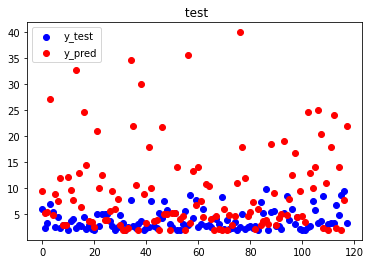

In [56]:
plotGraph(main_df['cocomoII_refactoring_perc_time_taken'], main_df['refactoring_perc_time_taken'],' test')

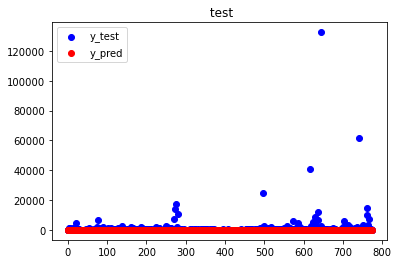

In [13]:
plotGraph(main_df['cocomoII_time_taken'], main_df['refactoring_perc_time_taken'],' test')

In [14]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [15]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



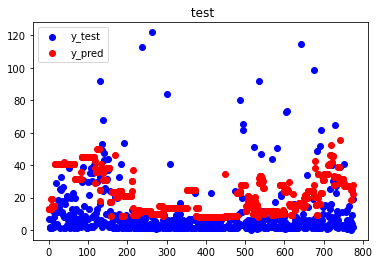

In [16]:
plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x271081e0908>,
 'caps': [<matplotlib.lines.Line2D at 0x271081f0048>,
 'boxes': [<matplotlib.lines.Line2D at 0x271081e07b8>],
 'medians': [<matplotlib.lines.Line2D at 0x271081f0748>],
 'fliers': [<matplotlib.lines.Line2D at 0x271081f0ac8>],
 'means': []}

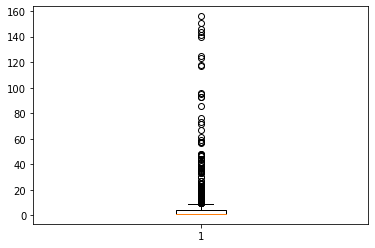

In [17]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x27108252940>,
 'caps': [<matplotlib.lines.Line2D at 0x2710825e080>,
 'boxes': [<matplotlib.lines.Line2D at 0x271082527f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2710825e780>],
 'fliers': [<matplotlib.lines.Line2D at 0x2710825eb00>],
 'means': []}

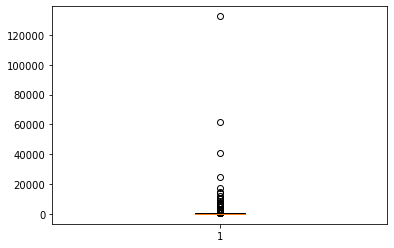

In [18]:
plt.boxplot(main_df['cocomoII_time_taken'])

In [55]:
main_df = main_df[main_df['cocomoII_refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['cocomoII_refactoring_perc_time_taken'] <= 40]

main_df = main_df[main_df['refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]

#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 24]
#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

{'whiskers': [<matplotlib.lines.Line2D at 0x2710b875d30>,
 'caps': [<matplotlib.lines.Line2D at 0x2710b881470>,
 'boxes': [<matplotlib.lines.Line2D at 0x2710b875be0>],
 'medians': [<matplotlib.lines.Line2D at 0x2710b881b70>],
 'fliers': [<matplotlib.lines.Line2D at 0x2710b881ef0>],
 'means': []}

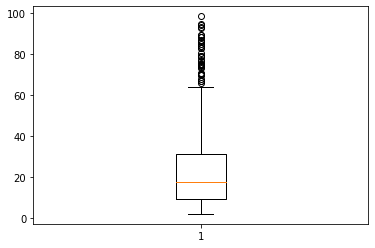

In [40]:
plt.boxplot(main_df['cocomoII_refactoring_perc_time_taken'])

In [41]:
main_df['cocomoII_time_taken'].value_counts()

2.06976      8
89.51712     6
6.20928      5
20.18016     5
75.02880     5
            ..
99.86592     1
82.79040     1
100.90080    1
113.83680    1
431.02752    1
Name: cocomoII_time_taken, Length: 394, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x2710b91cb00>,
 'caps': [<matplotlib.lines.Line2D at 0x2710b927240>,
 'boxes': [<matplotlib.lines.Line2D at 0x2710b91c9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x2710b927940>],
 'fliers': [<matplotlib.lines.Line2D at 0x2710b927cc0>],
 'means': []}

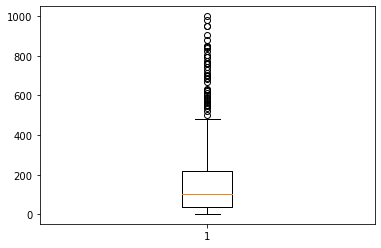

In [42]:
plt.boxplot(main_df['cocomoII_time_taken'])

In [43]:
main_df = main_df.fillna(0)

In [44]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,cocomoII_refactoring_perc_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2.000000,2,2,0.000000,8,1.000000,15.000000,4.13952,4.13952,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1.000000,1,1,0.000000,346,0.225434,1.000000,179.03424,40.36032,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1.500000,1,2,0.707107,35,1.000000,1.000000,18.11040,18.11040,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,7.833333,1,13,4.018895,194,0.185567,3.711340,100.38336,18.62784,1.0
6,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1.000000,1,1,0.000000,175,0.274286,1.097143,90.55200,24.83712,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,3.769231,1,7,1.964427,615,0.053659,1.000000,318.22560,17.07552,0.0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,2.000000,1,3,0.866025,16,0.750000,18.750000,8.27904,6.20928,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,5.500000,1,10,2.946898,1696,0.004127,1.000000,877.57824,3.62208,9.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1.000000,1,1,0.000000,4,1.000000,93.000000,2.06976,2.06976,19.4


(array([195., 156.,  92.,  48.,  28.,  28.,  10.,  18.,  14.,   7.]),
 array([ 2.06976 , 11.694144, 21.318528, 30.942912, 40.567296, 50.19168 ,
        59.816064, 69.440448, 79.064832, 88.689216, 98.3136  ]),
 <a list of 10 Patch objects>)

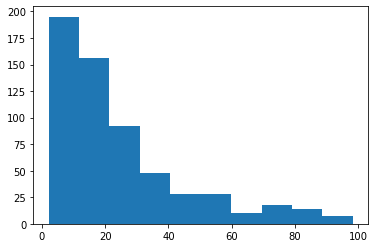

In [45]:
plt.hist(main_df['cocomoII_refactoring_perc_time_taken'])

(array([49., 55., 39., 52., 53., 27., 41., 35., 24., 30., 19., 19., 18.,
        14.,  8.,  8.,  9.,  6.,  5.,  8.,  7.,  8.,  6.,  7.,  4.,  2.,
         3.,  1.,  5.,  3.,  8.,  2.,  4.,  4.,  2.,  4.,  2.,  2.,  2.,
         1.]),
 array([ 2.06976 ,  4.475856,  6.881952,  9.288048, 11.694144, 14.10024 ,
        16.506336, 18.912432, 21.318528, 23.724624, 26.13072 , 28.536816,
        30.942912, 33.349008, 35.755104, 38.1612  , 40.567296, 42.973392,
        45.379488, 47.785584, 50.19168 , 52.597776, 55.003872, 57.409968,
        59.816064, 62.22216 , 64.628256, 67.034352, 69.440448, 71.846544,
        74.25264 , 76.658736, 79.064832, 81.470928, 83.877024, 86.28312 ,
        88.689216, 91.095312, 93.501408, 95.907504, 98.3136  ]),
 <a list of 40 Patch objects>)

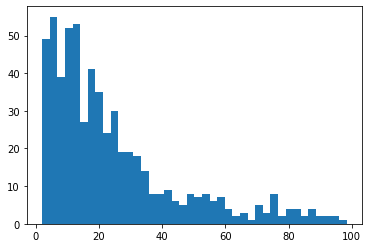

In [46]:
plt.hist(main_df['cocomoII_refactoring_perc_time_taken'],bins=40)

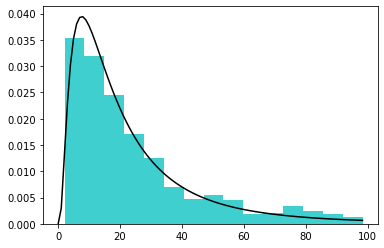

In [48]:
s, loc, scale = sp.stats.lognorm.fit(main_df['cocomoII_refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['cocomoII_refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['cocomoII_refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['cocomoII_refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

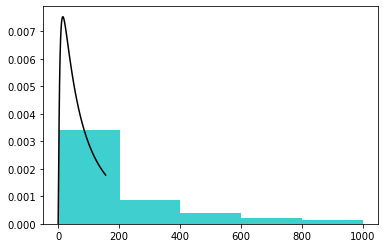

In [38]:
s, loc, scale = sp.stats.lognorm.fit(main_df['cocomoII_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['cocomoII_time_taken'], bins=5, density=True, color='c', alpha=0.75)
xmin = main_df['cocomoII_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

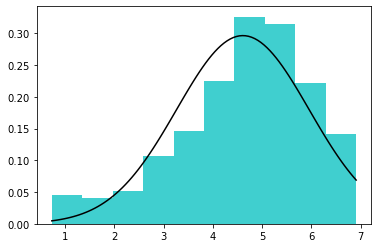

In [30]:
logdata = np.log(main_df['cocomoII_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [151]:
len(main_df)

243

In [152]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [153]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [33]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [34]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [35]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [36]:
X_col = final_col.copy()
X_col.remove('cocomoII_time_taken')
Y_col = ['cocomoII_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [37]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.00,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.0,2.0,...,58.000000,58.0,58.0,0.000000,17.0,17.0,17.0,0.0,85.000000,61.000000
1,12.00,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.0,1.0,...,68.000000,68.0,68.0,0.000000,17.0,17.0,17.0,0.0,3.000000,78.000000
2,30.00,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.0,1.0,...,103.000000,103.0,103.0,0.000000,1.0,1.0,1.0,0.0,78.000000,322.000000
3,23.25,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.0,1.0,...,121.333333,37.0,320.0,98.919006,1.0,1.0,1.0,0.0,57.583333,222.666667
5,25.00,25.0,25.0,0.000000,32.000000,32.0,32.0,0.000000,1.0,1.0,...,166.000000,166.0,166.0,0.000000,1025.0,1025.0,1025.0,0.0,51.000000,321.000000


In [38]:
y.head()

,cocomoII_time_taken
0,4.13952
1,179.03424
2,18.11040
3,100.38336
5,191.97024


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [40]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tanji\AppData\Local\Temp\tmp8x4y24l9
  JVM stdout: C:\Users\tanji\AppData\Local\Temp\tmp8x4y24l9\h2o_tanji_started_from_python.out
  JVM stderr: C:\Users\tanji\AppData\Local\Temp\tmp8x4y24l9\h2o_tanji_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,4 months and 11 days !!!
H2O_cluster_name:,H2O_from_python_tanji_60ijya
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [42]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "cocomoII_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [44]:
train[y].types

{'cocomoII_time_taken': 'real'}

In [45]:
aml = H2OAutoML(max_models=10, seed=16, exclude_algos=['XGBoost', 'GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [46]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20220114_105936,39832,199.58,39832,142.946,1.37602
StackedEnsemble_AllModels_AutoML_20220114_105936,40182.2,200.455,40182.2,142.995,1.3757
GBM_4_AutoML_20220114_105936,40600.5,201.496,40600.5,142.276,1.36614
DRF_1_AutoML_20220114_105936,41033.8,202.568,41033.8,144.664,1.36642
GBM_5_AutoML_20220114_105936,41365.1,203.384,41365.1,146.615,1.39525
GBM_grid__1_AutoML_20220114_105936_model_1,41572,203.892,41572,146.336,1.38709
GBM_2_AutoML_20220114_105936,41990.5,204.916,41990.5,143.689,1.368
XRT_1_AutoML_20220114_105936,42030.6,205.014,42030.6,147.075,1.37115
GBM_3_AutoML_20220114_105936,42307.1,205.687,42307.1,144.385,1.37158
GBM_1_AutoML_20220114_105936,43243,207.949,43243,146.518,1.36501


In [47]:
model = h2o.get_model(lb[0,'model_id'])

In [48]:
model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20220114_105936

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 14101.367922320875
RMSE: 118.7491807227354
MAE: 84.70236855820887
RMSLE: 1.090903425880476
R^2: 0.675779383405176
Mean Residual Deviance: 14101.367922320875
Null degrees of freedom: 469
Residual degrees of freedom: 467
Null deviance: 20441768.91987511
Residual deviance: 6627642.923490811
AIC: 5832.194952303539

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 39832.02389624136
RMSE: 199.57961793790807
MAE: 142.94616217209258
RMSLE: 1.3760176318030473
R^2: 0.08417655513993527
Mean Residual Deviance: 39832.02389624136
Null degrees of freedom: 469
Residual degrees of freedom: 466
Null deviance: 20555328.94829811
Residual deviance: 18721051.231233437
AIC: 6322.242670688745


In [49]:
preds = model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [50]:
preds

predict
252.77
277.786
198.46
290.919
221.386
258.525
192.003
156.289
159.542
179.151


In [51]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

195.374695    1
73.489836     1
114.847334    1
315.500177    1
125.953043    1
             ..
123.068791    1
187.793899    1
181.195496    1
149.823881    1
178.826164    1
Name: predict, Length: 215, dtype: int64

In [52]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,cocomoII_time_taken
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,4.13952
12,12,12,0,8,8,8,0,1,1,1,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,5,5,5,0,2,2,2,0,8,8,8,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,4,4,4,0,80,80,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,2,2,2,0,16,16,16,0,0,0,0,0,16,16,16,0,1,1,1,0,2,2,2,0,0,0,0,0,0,0,0,0,68,68,68,0,17,17,17,0,3,78,179.034
25,25,25,0,32,32,32,0,1,1,1,0,65,65,65,0,9,9,9,0,23,23,23,0,1,1,1,0,18,18,18,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,7,7,7,0,3,3,3,0,1,1,1,0,4,4,4,0,2,2,2,0,0,0,0,0,4,4,4,0,0,0,0,0,46,46,46,0,265,265,265,0,6,6,6,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,80,80,80,0,14,14,14,0,49,49,49,0,32,32,32,0,48,48,48,0,2,2,2,0,0,0,0,0,0,0,0,0,1,1,1,0,166,166,166,0,1025,1025,1025,0,51,321,191.97
8,8,8,0,8,8,8,0,1,1,1,0,4,4,4,0,15,15,15,0,6,6,6,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

{'whiskers': [<matplotlib.lines.Line2D at 0x25b17856400>,
 'caps': [<matplotlib.lines.Line2D at 0x25b17856b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x25b178562b0>],
 'medians': [<matplotlib.lines.Line2D at 0x25b1785c278>],
 'fliers': [<matplotlib.lines.Line2D at 0x25b1785c5f8>],
 'means': []}

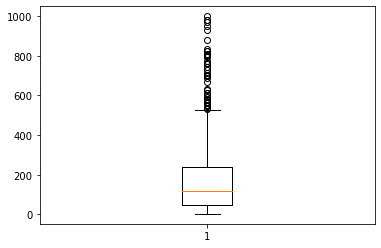

In [53]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['cocomoII_time_taken'])

In [174]:
main_df['actual_num_of_classes_touched_max'].mean()

10.584362139917696

In [175]:
len(main_df['actual_num_of_classes_touched_max'])

243

In [176]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

243

In [177]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

241

In [178]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

234

In [179]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

206

In [180]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

166

{'whiskers': [<matplotlib.lines.Line2D at 0x23523831780>,
 'caps': [<matplotlib.lines.Line2D at 0x23523831eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x23523831630>],
 'medians': [<matplotlib.lines.Line2D at 0x2352383c5f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2352383c978>],
 'means': []}

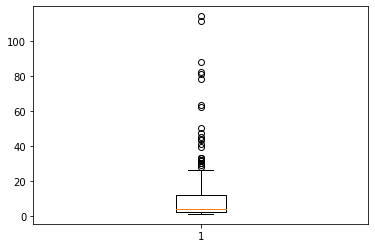

In [181]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [182]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x23523889550>,
 'caps': [<matplotlib.lines.Line2D at 0x23523889c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x23523889400>],
 'medians': [<matplotlib.lines.Line2D at 0x235238943c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x23523894748>],
 'means': []}

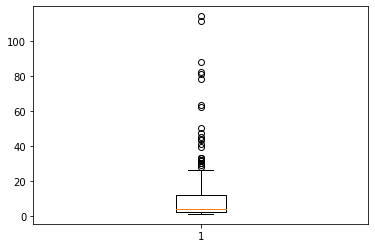

In [183]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x235238e5780>,
 'caps': [<matplotlib.lines.Line2D at 0x235238e5eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x235238e5630>],
 'medians': [<matplotlib.lines.Line2D at 0x235238f1588>],
 'fliers': [<matplotlib.lines.Line2D at 0x235238f18d0>],
 'means': []}

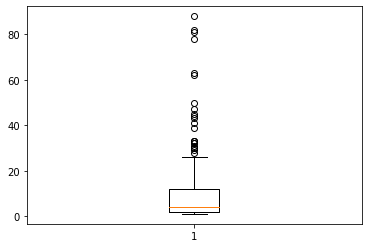

In [184]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [185]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [186]:
pd_preds

,predict,actual_time_taken
0,7.633855,15.000000
1,9.313968,10.000000
2,7.595525,5.340909
3,8.650755,5.478927
4,7.315348,11.273423
...,...,...
66,4.439499,17.814433
67,7.224448,6.947368
68,7.186694,2.579845
69,6.419956,18.750000


{'whiskers': [<matplotlib.lines.Line2D at 0x2352394d358>,
 'caps': [<matplotlib.lines.Line2D at 0x2352394da90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2352394d240>],
 'medians': [<matplotlib.lines.Line2D at 0x235239581d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23523958550>],
 'means': []}

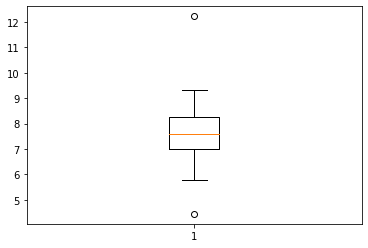

In [187]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x235239b15c0>,
 'caps': [<matplotlib.lines.Line2D at 0x235239b1cf8>,
 'boxes': [<matplotlib.lines.Line2D at 0x235239b14a8>],
 'medians': [<matplotlib.lines.Line2D at 0x235239be438>],
 'fliers': [<matplotlib.lines.Line2D at 0x235239be7b8>],
 'means': []}

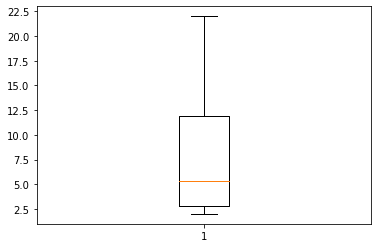

In [188]:
plt.boxplot(pd_preds['actual_time_taken'])

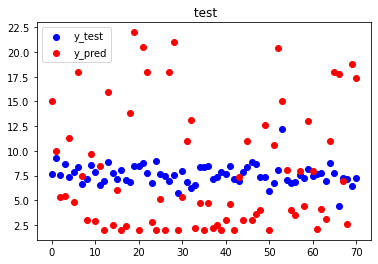

In [189]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],' test')

In [190]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

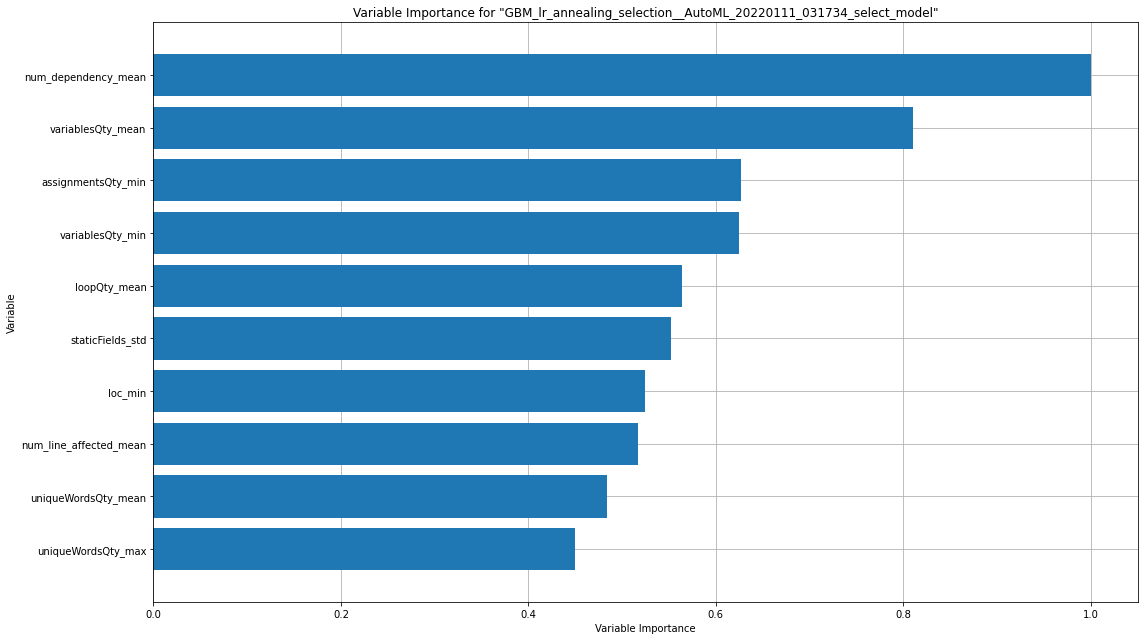

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

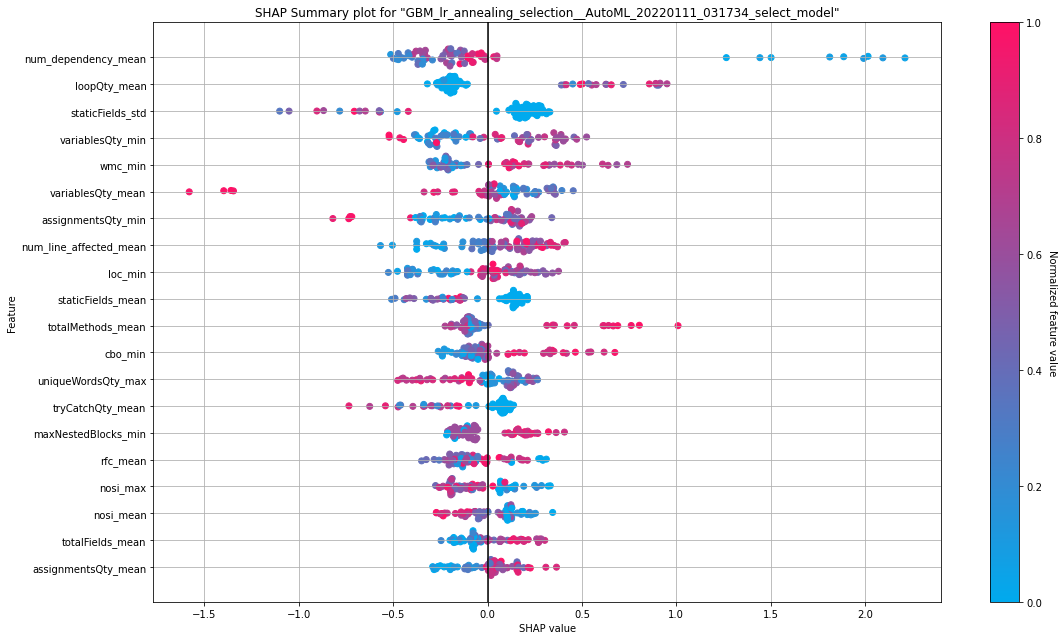

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

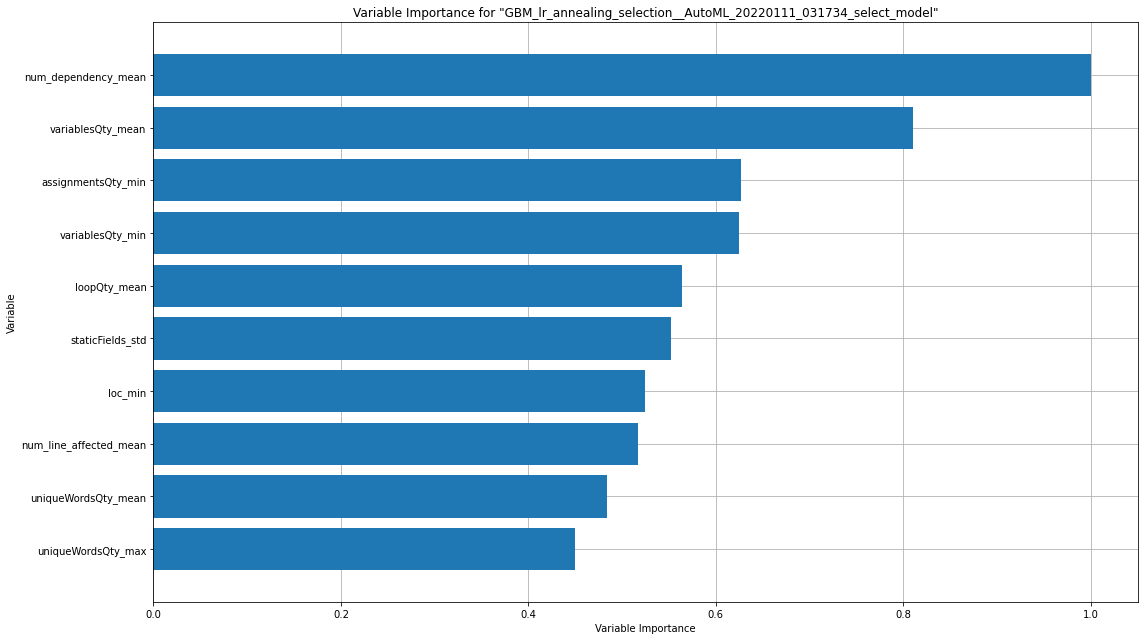

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

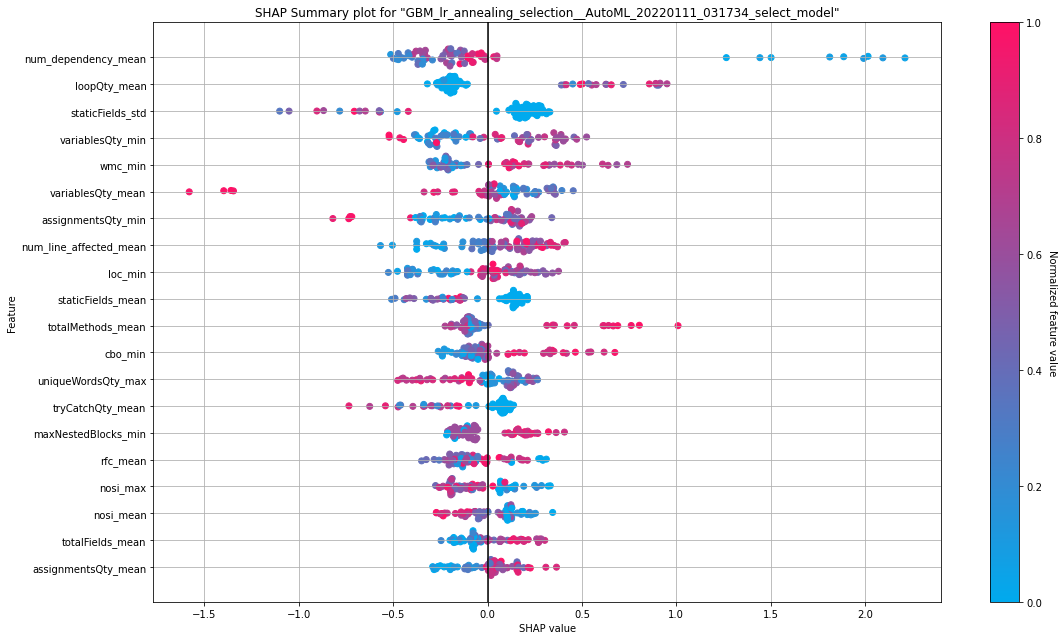

In [191]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [65]:
#aml.explain_row(test, row_index=0)

In [192]:
#h2o.shutdown()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_a322 closed.
